# Identifying Entities in Healthcare Data

### Workspace set up: Import and Install useful packages.

In [1]:
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

### Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

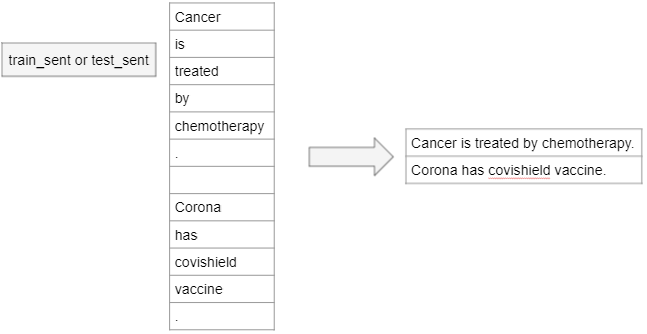

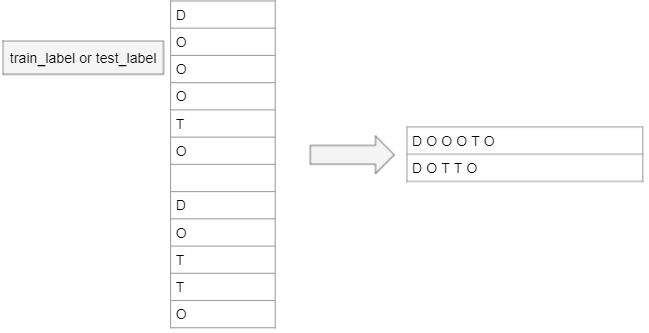

In [2]:
with open('/Users/Kirwe-Macbook/Desktop/PGDML/NLP/Syntactic processing assignment/train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()

with open('/Users/Kirwe-Macbook/Desktop/PGDML/NLP/Syntactic processing assignment/train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()

with open('/Users/Kirwe-Macbook/Desktop/PGDML/NLP/Syntactic processing assignment/test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()

with open('/Users/Kirwe-Macbook/Desktop/PGDML/NLP/Syntactic processing assignment/test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()

In [3]:
len(train_sentences), len(train_labels),len(test_sentences), len(test_labels)

(48501, 48501, 19674, 19674)

### Data preprocessing for train sentences

In [4]:
processed_train_sentences= []
sentence = []
for word in train_sentences:
    if word.isspace():
        res = " ".join(sentence)
        processed_train_sentences.append(res)
        sentence = []
    else:
        word=word.strip()
        sentence.append(word)

In [5]:
processed_train_sentences[0]

'All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )'

### Data preprocessing for test sentences

In [6]:
processed_test_sentences= []
sentence = []
for word in test_sentences:
    if word.isspace():
        res = " ".join(sentence)
        processed_test_sentences.append(res)
        sentence = []
    else:
        word=word.strip()
        sentence.append(word)

In [7]:
processed_test_sentences[46]

'< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy'

### Data preprocessing for train labels

In [8]:
processed_train_labels= []
labels = []
for word in train_labels:
    if word.isspace():
        res = " ".join(labels)
        processed_train_labels.append(res)
        labels = []
    else:
        word=word.strip()
        labels.append(word)

In [9]:
processed_train_labels[0]

'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O'

### Data preprocessing for test labels

In [10]:
processed_test_labels= []
labels = []
for word in test_labels:
    if word.isspace():
        res = " ".join(labels)
        processed_test_labels.append(res)
        labels = []
    else:
        word=word.strip()
        labels.append(word)

In [11]:
processed_test_labels[46]

'O O O O O O O O O O O O O O O O O O O O O O O O O'

In [12]:
for x in range(0,5):
    print("**********")
    print("Sentence number %d" %x)
    print(processed_train_sentences[x])
    print("Label number %d" %x)
    print(processed_train_labels[x])

**********
Sentence number 0
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label number 0
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
**********
Sentence number 1
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label number 1
O O O O O O O O O O O O O O O O O O O O O O O O O
**********
Sentence number 2
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label number 2
O O O O O O O O O O O O O O O
**********
Sentence number 3
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Label number 3
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

In [13]:
for x in range(0,5):
    print("**********")
    print("Sentence number %d" %x)
    print(processed_test_sentences[x])
    print("Label number %d" %x)
    print(processed_test_labels[x])

**********
Sentence number 0
Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Label number 0
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
**********
Sentence number 1
As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Label number 1
O O O O O O O O O O O O O O O O O O O
**********
Sentence number 2
The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
Label number 2
O O O O O O O O O O O O O O O O O O O O O O O O
**********
Sentence number 3
There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )
Label number 3
O O O O O O O O O O O O O O

### Count the number of sentences in the processed train and test dataset 

In [14]:
len(processed_train_sentences), len(processed_test_sentences)

(2599, 1056)

### Count the number of lines of labels in the processed train and test dataset.

In [15]:
len(processed_train_labels), len(processed_test_labels)

(2599, 1056)

## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [16]:
model = spacy.load("en_core_web_sm")

train_count = 0

for i in range(0,len(processed_train_sentences)):
    sent = model(processed_train_sentences[i])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            train_count=train_count+1

print("TRAIN SET = Total count of words which are NOUN or PROPN = ", train_count)

TRAIN SET = Total count of words which are NOUN or PROPN =  17392


In [17]:
test_count = 0

for i in range(0,len(processed_test_sentences)):
    sent = model(processed_test_sentences[i])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            test_count=test_count+1

print("TEST SET = Total count of words which are NOUN or PROPN = ", test_count)

TEST SET = Total count of words which are NOUN or PROPN =  6910


### Checking for POS tag of one specific sentence for quick overview

In [18]:
for i in range(0,len(processed_train_sentences[0])):
    sent = model(processed_train_sentences[i])

    for token in sent:
        print(token.text, "--", token.lemma_, "--", token.pos_)

All -- all -- DET
live -- live -- ADJ
births -- birth -- NOUN
> -- > -- X
or -- or -- CCONJ
= -- = -- SYM
23 -- 23 -- NUM
weeks -- week -- NOUN
at -- at -- ADP
the -- the -- DET
University -- University -- PROPN
of -- of -- ADP
Vermont -- Vermont -- PROPN
in -- in -- ADP
1995 -- 1995 -- NUM
( -- ( -- PUNCT
n -- n -- NOUN
= -- = -- SYM
2395 -- 2395 -- NUM
) -- ) -- PUNCT
were -- be -- AUX
retrospectively -- retrospectively -- ADV
analyzed -- analyze -- VERB
for -- for -- ADP
delivery -- delivery -- NOUN
route -- route -- NOUN
, -- , -- PUNCT
indication -- indication -- NOUN
for -- for -- ADP
cesarean -- cesarean -- PROPN
, -- , -- PUNCT
gestational -- gestational -- ADJ
age -- age -- NOUN
, -- , -- PUNCT
parity -- parity -- NOUN
, -- , -- PUNCT
and -- and -- CCONJ
practice -- practice -- NOUN
group -- group -- NOUN
( -- ( -- PUNCT
to -- to -- PART
reflect -- reflect -- VERB
risk -- risk -- NOUN
status -- status -- NOUN
) -- ) -- PUNCT
The -- the -- DET
total -- total -- ADJ
cesarean -- 

Our -- -PRON- -- DET
aim -- aim -- NOUN
was -- be -- AUX
to -- to -- PART
investigate -- investigate -- VERB
the -- the -- DET
contribution -- contribution -- NOUN
of -- of -- ADP
certain -- certain -- ADJ
antenatally -- antenatally -- ADV
detectable -- detectable -- ADJ
markers -- marker -- NOUN
leading -- lead -- VERB
to -- to -- ADP
the -- the -- DET
diagnosis -- diagnosis -- NOUN
of -- of -- ADP
trisomic -- trisomic -- NOUN
fetuses -- fetus -- NOUN
we -- -PRON- -- PRON
observed -- observe -- VERB
over -- over -- ADP
a -- a -- DET
period -- period -- NOUN
of -- of -- ADP
6 -- 6 -- NUM
years -- year -- NOUN
Down -- down -- ADP
syndrome -- syndrome -- NOUN
( -- ( -- PUNCT
12 -- 12 -- NUM
cases -- case -- NOUN
) -- ) -- PUNCT
and -- and -- CCONJ
Edward -- Edward -- PROPN
syndrome -- syndrome -- NOUN
( -- ( -- PUNCT
11 -- 11 -- NUM
cases -- case -- NOUN
) -- ) -- PUNCT
were -- be -- AUX
the -- the -- DET
most -- most -- ADV
common -- common -- ADJ
trisomies -- trisomy -- NOUN
, -- , -- 

Omphalocele -- Omphalocele -- PROPN
- -- - -- PUNCT
Exstrophy -- Exstrophy -- PROPN
- -- - -- PUNCT
Imperforate -- Imperforate -- PROPN
anus -- anus -- ADJ
- -- - -- PUNCT
Spinal -- spinal -- ADJ
defects -- defect -- NOUN
( -- ( -- PUNCT
OEIS -- OEIS -- PROPN
complex -- complex -- NOUN
) -- ) -- PUNCT
, -- , -- PUNCT
a -- a -- DET
combination -- combination -- NOUN
of -- of -- ADP
omphalocele -- omphalocele -- PROPN
, -- , -- PUNCT
exstrophy -- exstrophy -- NOUN
of -- of -- ADP
the -- the -- DET
bladder -- bladder -- NOUN
, -- , -- PUNCT
an -- an -- DET
imperforate -- imperforate -- ADJ
anus -- anus -- NOUN
and -- and -- CCONJ
spinal -- spinal -- ADJ
defects -- defect -- NOUN
, -- , -- PUNCT
arises -- arise -- VERB
from -- from -- ADP
a -- a -- DET
single -- single -- ADJ
localized -- localize -- VERB
defect -- defect -- NOUN
in -- in -- ADP
the -- the -- DET
early -- early -- ADJ
development -- development -- NOUN
of -- of -- ADP
the -- the -- DET
mesoderm -- mesoderm -- NOUN
that -- 

Critical -- critical -- ADJ
values -- value -- NOUN
for -- for -- ADP
chromosomal -- chromosomal -- ADJ
regional -- regional -- ADJ
follow -- follow -- NOUN
- -- - -- PUNCT
up -- up -- NOUN
were -- be -- AUX
a -- a -- DET
P -- p -- NOUN
value -- value -- NOUN
of -- of -- ADP
.05 -- .05 -- PUNCT
or -- or -- CCONJ
less -- less -- ADJ
for -- for -- ADP
affected -- affected -- ADJ
relative -- relative -- ADJ
pair -- pair -- NOUN
analysis -- analysis -- NOUN
or -- or -- CCONJ
sibpair -- sibpair -- NOUN
analysis -- analysis -- NOUN
, -- , -- PUNCT
a -- a -- DET
parametric -- parametric -- ADJ
lod -- lod -- NOUN
score -- score -- NOUN
of -- of -- ADP
1.0 -- 1.0 -- NUM
or -- or -- CCONJ
greater -- great -- ADJ
, -- , -- PUNCT
or -- or -- CCONJ
both -- both -- DET
Regional -- regional -- ADJ
follow -- follow -- NOUN
- -- - -- PUNCT
up -- up -- NOUN
included -- include -- VERB
analysis -- analysis -- NOUN
of -- of -- ADP
additional -- additional -- ADJ
markers -- marker -- NOUN
and -- and -- CCO

OBJECTIVE -- objective -- ADJ
: -- : -- PUNCT
To -- to -- PART
investigate -- investigate -- VERB
phenotypic -- phenotypic -- ADJ
characteristics -- characteristic -- NOUN
of -- of -- ADP
families -- family -- NOUN
potentially -- potentially -- ADV
linked -- link -- VERB
to -- to -- ADP
the -- the -- DET
hereditary -- hereditary -- ADJ
prostate -- prostate -- NOUN
cancer -- cancer -- NOUN
1 -- 1 -- NUM
( -- ( -- PUNCT
HPC1 -- HPC1 -- PROPN
) -- ) -- PUNCT
locus -- locus -- NOUN
on -- on -- ADP
chromosome -- chromosome -- NOUN
1q24 -- 1q24 -- NUM
- -- - -- SYM
25 -- 25 -- NUM
Prostate -- prostate -- NOUN
cancer -- cancer -- NOUN
cases -- case -- NOUN
from -- from -- ADP
the -- the -- DET
National -- National -- PROPN
Cancer -- Cancer -- PROPN
Data -- Data -- PROPN
Base -- Base -- PROPN
were -- be -- AUX
used -- use -- VERB
as -- as -- SCONJ
a -- a -- DET
reference -- reference -- NOUN
population -- population -- NOUN
for -- for -- ADP
comparison -- comparison -- NOUN
MAIN -- main -- ADJ

The -- the -- DET
3 -- 3 -- NUM
regions -- region -- NOUN
include -- include -- VERB
HLA -- HLA -- PROPN
on -- on -- ADP
chromosome -- chromosome -- NOUN
6p21.3 -- 6p21.3 -- NUM
, -- , -- PUNCT
APOE -- APOE -- PROPN
on -- on -- ADP
chromosome -- chromosome -- NOUN
19ql -- 19ql -- NUM
3.2 -- 3.2 -- NUM
, -- , -- PUNCT
and -- and -- CCONJ
MBP -- MBP -- PROPN
( -- ( -- PUNCT
myelin -- myelin -- PROPN
basic -- basic -- ADJ
protein -- protein -- NOUN
) -- ) -- PUNCT
on -- on -- ADP
chromosome -- chromosome -- NOUN
18q23 -- 18q23 -- NOUN
SUBJECTS -- subject -- NOUN
: -- : -- PUNCT
A -- a -- DET
total -- total -- NOUN
of -- of -- ADP
120 -- 120 -- NUM
Caucasian -- caucasian -- ADJ
patients -- patient -- NOUN
with -- with -- ADP
MS -- MS -- PROPN
and -- and -- CCONJ
107 -- 107 -- NUM
unrelated -- unrelated -- ADJ
control -- control -- NOUN
individuals -- individual -- NOUN
from -- from -- ADP
California -- California -- PROPN
, -- , -- PUNCT
and -- and -- CCONJ
32 -- 32 -- NUM
patients -- pati

All -- all -- DET
114 -- 114 -- NUM
sarcomas -- sarcoma -- NOUN
of -- of -- ADP
diverse -- diverse -- ADJ
histologic -- histologic -- ADJ
types -- type -- NOUN
occurred -- occur -- VERB
in -- in -- ADP
patients -- patient -- NOUN
with -- with -- ADP
hereditary -- hereditary -- ADJ
retinoblastoma -- retinoblastoma -- NOUN
For -- for -- ADP
soft -- soft -- ADJ
tissue -- tissue -- NOUN
sarcomas -- sarcomas -- PROPN
, -- , -- PUNCT
the -- the -- DET
RRs -- rr -- NOUN
showed -- show -- VERB
a -- a -- DET
stepwise -- stepwise -- ADJ
increase -- increase -- NOUN
at -- at -- ADV
all -- all -- DET
dose -- dose -- ADJ
categories -- category -- NOUN
, -- , -- PUNCT
and -- and -- CCONJ
were -- be -- AUX
statistically -- statistically -- ADV
significant -- significant -- ADJ
at -- at -- ADP
10 -- 10 -- NUM
to -- to -- PART
29.9 -- 29.9 -- NUM
Gy -- Gy -- PROPN
and -- and -- CCONJ
30 -- 30 -- NUM
to -- to -- PART
59.9 -- 59.9 -- NUM
Gy -- Gy -- NOUN
< -- < -- X
TO_SEE -- to_see -- X
> -- > -- X
CONC

Most -- Most -- ADJ
( -- ( -- PUNCT
85 -- 85 -- NUM
% -- % -- NOUN
) -- ) -- PUNCT
viewed -- view -- VERB
pregnancy -- pregnancy -- NOUN
as -- as -- SCONJ
inappropriate -- inappropriate -- ADJ
for -- for -- ADP
HIV -- HIV -- PROPN
infected -- infected -- ADJ
women -- woman -- NOUN
and -- and -- CCONJ
primarily -- primarily -- ADV
drug -- drug -- NOUN
users -- user -- NOUN
( -- ( -- PUNCT
P -- p -- NOUN
= -- = -- SYM
0.06 -- 0.06 -- NUM
) -- ) -- PUNCT
would -- would -- VERB
abort -- abort -- VERB
if -- if -- SCONJ
HIV -- HIV -- PROPN
infected -- infect -- VERB
Over -- over -- ADP
half -- half -- DET
thought -- think -- VERB
HIV -- HIV -- PROPN
transmission -- transmission -- NOUN
occurred -- occur -- VERB
most -- most -- ADJ
times -- time -- NOUN
or -- or -- CCONJ
always -- always -- ADV
Only -- only -- ADV
20 -- 20 -- NUM
% -- % -- NOUN
had -- have -- AUX
heard -- hear -- VERB
of -- of -- ADP
a -- a -- DET
drug -- drug -- NOUN
to -- to -- PART
reduce -- reduce -- VERB
this -- this -- 

detection -- detection -- NOUN
of -- of -- ADP
adverse -- adverse -- ADJ
drug -- drug -- NOUN
effects -- effect -- NOUN
may -- may -- VERB
further -- further -- ADV
improve -- improve -- VERB
strategies -- strategy -- NOUN
for -- for -- ADP
pharmacovigilance -- pharmacovigilance -- NOUN
OBJECTIVE -- objective -- ADJ
: -- : -- PUNCT
To -- to -- PART
study -- study -- VERB
the -- the -- DET
safety -- safety -- NOUN
and -- and -- CCONJ
efficacy -- efficacy -- NOUN
of -- of -- ADP
methylphenidate -- methylphenidate -- NOUN
in -- in -- ADP
children -- child -- NOUN
with -- with -- ADP
the -- the -- DET
dual -- dual -- ADJ
diagnosis -- diagnosis -- NOUN
of -- of -- ADP
epilepsy -- epilepsy -- NOUN
and -- and -- CCONJ
attention -- attention -- NOUN
deficit -- deficit -- NOUN
hyperactivity -- hyperactivity -- NOUN
disorder -- disorder -- NOUN
( -- ( -- PUNCT
ADHD -- ADHD -- PROPN
) -- ) -- PUNCT
STUDY -- STUDY -- PROPN
DESIGN -- DESIGN -- PROPN
: -- : -- PUNCT
Thirty -- thirty -- NUM
children 

The -- the -- DET
sequential -- sequential -- ADJ
replacement -- replacement -- NOUN
of -- of -- ADP
the -- the -- DET
four -- four -- NUM
tryptophan -- tryptophan -- PROPN
residues -- residue -- NOUN
in -- in -- ADP
gramicidin -- gramicidin -- PROPN
A -- a -- DET
at -- at -- ADP
positions -- position -- NOUN
15 -- 15 -- NUM
, -- , -- PUNCT
13 -- 13 -- NUM
, -- , -- PUNCT
11 -- 11 -- NUM
, -- , -- PUNCT
and -- and -- CCONJ
9 -- 9 -- NUM
with -- with -- ADP
glycine -- glycine -- NOUN
showed -- show -- VERB
that -- that -- SCONJ
there -- there -- PRON
was -- be -- AUX
no -- no -- DET
detectable -- detectable -- ADJ
effect -- effect -- NOUN
at -- at -- ADP
position -- position -- NOUN
15 -- 15 -- NUM
but -- but -- CCONJ
increasing -- increase -- VERB
heterogeneity -- heterogeneity -- NOUN
of -- of -- ADP
species -- specie -- NOUN
in -- in -- ADP
the -- the -- DET
micelles -- micelle -- NOUN
proceeding -- proceed -- VERB
toward -- toward -- ADP
the -- the -- DET
interior -- interior -- NOU

The -- the -- DET
results -- result -- NOUN
indicate -- indicate -- VERB
that -- that -- SCONJ
the -- the -- DET
wavelet -- wavelet -- NOUN
- -- - -- PUNCT
transform -- transform -- NOUN
method -- method -- NOUN
can -- can -- VERB
provide -- provide -- VERB
efficient -- efficient -- ADJ
and -- and -- CCONJ
accurate -- accurate -- ADJ
quantification -- quantification -- NOUN
of -- of -- ADP
MRS -- MRS -- PROPN
data -- datum -- NOUN
BACKGROUND -- background -- NOUN
: -- : -- PUNCT
Antiplatelet -- antiplatelet -- ADP
therapy -- therapy -- NOUN
with -- with -- ADP
aspirin -- aspirin -- NOUN
and -- and -- CCONJ
systematic -- systematic -- ADJ
anticoagulation -- anticoagulation -- NOUN
with -- with -- ADP
warfarin -- warfarin -- NOUN
reduce -- reduce -- VERB
cardiovascular -- cardiovascular -- ADJ
morbidity -- morbidity -- NOUN
and -- and -- CCONJ
mortality -- mortality -- NOUN
after -- after -- ADP
myocardial -- myocardial -- ADJ
infarction -- infarction -- NOUN
when -- when -- ADV
given --

We -- -PRON- -- PRON
report -- report -- VERB
the -- the -- DET
primary -- primary -- ADJ
clinical -- clinical -- ADJ
endpoints -- endpoint -- NOUN
( -- ( -- PUNCT
cardiac -- cardiac -- ADJ
ischaemic -- ischaemic -- ADJ
death -- death -- NOUN
, -- , -- PUNCT
myocardial -- myocardial -- ADJ
infarction -- infarction -- NOUN
, -- , -- PUNCT
and -- and -- CCONJ
severe -- severe -- ADJ
recurrent -- recurrent -- ADJ
ischaemia -- ischaemia -- NOUN
) -- ) -- PUNCT
, -- , -- PUNCT
assessed -- assess -- VERB
at -- at -- ADP
day -- day -- NOUN
31 -- 31 -- NUM
, -- , -- PUNCT
in -- in -- ADP
202 -- 202 -- NUM
patients -- patient -- NOUN
on -- on -- ADP
an -- an -- DET
intention -- intention -- NOUN
- -- - -- PUNCT
to -- to -- ADP
- -- - -- PUNCT
treat -- treat -- VERB
basis -- basis -- NOUN
FINDINGS -- finding -- NOUN
: -- : -- PUNCT
A -- a -- DET
statistically -- statistically -- ADV
significant -- significant -- ADJ
reduction -- reduction -- NOUN
in -- in -- ADP
the -- the -- DET
primary -- prim

48 -- 48 -- NUM
( -- ( -- PUNCT
28 -- 28 -- NUM
% -- % -- NOUN
) -- ) -- PUNCT
surgery -- surgery -- NOUN
- -- - -- PUNCT
group -- group -- NOUN
patients -- patient -- NOUN
had -- have -- AUX
severe -- severe -- ADJ
morbidity -- morbidity -- NOUN
compared -- compare -- VERB
with -- with -- ADP
19 -- 19 -- NUM
( -- ( -- PUNCT
12 -- 12 -- NUM
% -- % -- NOUN
) -- ) -- PUNCT
radiotherapy -- radiotherapy -- NOUN
- -- - -- PUNCT
group -- group -- NOUN
patients -- patient -- NOUN
( -- ( -- PUNCT
p -- p -- NOUN
= -- = -- SYM
0.0004 -- 0.0004 -- NUM
) -- ) -- PUNCT
The -- the -- DET
combination -- combination -- NOUN
of -- of -- ADP
surgery -- surgery -- NOUN
and -- and -- CCONJ
radiotherapy -- radiotherapy -- NOUN
has -- have -- AUX
the -- the -- DET
worst -- bad -- ADJ
morbidity -- morbidity -- NOUN
, -- , -- PUNCT
especially -- especially -- ADV
urological -- urological -- ADJ
complications -- complication -- NOUN
The -- the -- DET
optimum -- optimum -- ADJ
therapy -- therapy -- NOUN
for -- 

The -- the -- DET
miracidia -- miracidia -- NOUN
of -- of -- ADP
Fasciola -- Fasciola -- PROPN
hepatica -- hepatica -- PROPN
and -- and -- CCONJ
Trichobilharzia -- trichobilharzia -- ADJ
ocellata -- ocellata -- NOUN
approach -- approach -- VERB
their -- -PRON- -- DET
host -- host -- NOUN
snails -- snail -- NOUN
Lymnaea -- Lymnaea -- PROPN
truncatula -- truncatula -- NOUN
and -- and -- CCONJ
L. -- L. -- PROPN
stagnalis -- stagnalis -- PROPN
by -- by -- ADP
increasing -- increase -- VERB
their -- -PRON- -- DET
rate -- rate -- NOUN
of -- of -- ADP
change -- change -- NOUN
of -- of -- ADP
direction -- direction -- NOUN
( -- ( -- PUNCT
RCD -- RCD -- PROPN
) -- ) -- PUNCT
in -- in -- ADP
increasing -- increase -- VERB
gradients -- gradient -- NOUN
of -- of -- ADP
snail -- snail -- NOUN
- -- - -- PUNCT
conditioned -- condition -- VERB
water -- water -- NOUN
( -- ( -- PUNCT
SCW -- SCW -- PROPN
) -- ) -- PUNCT
, -- , -- PUNCT
and -- and -- CCONJ
they -- -PRON- -- PRON
perform -- perform -- VERB

This -- this -- DET
suggests -- suggest -- VERB
that -- that -- SCONJ
there -- there -- PRON
may -- may -- VERB
be -- be -- AUX
racial -- racial -- ADJ
differences -- difference -- NOUN
in -- in -- ADP
environmental -- environmental -- ADJ
exposure -- exposure -- NOUN
, -- , -- PUNCT
and -- and -- CCONJ
that -- that -- SCONJ
the -- the -- DET
intensity -- intensity -- NOUN
and -- and -- CCONJ
mode -- mode -- NOUN
of -- of -- ADP
delivery -- delivery -- NOUN
of -- of -- ADP
carcinogen -- carcinogen -- NOUN
insult -- insult -- NOUN
as -- as -- ADV
well -- well -- ADV
as -- as -- SCONJ
host -- host -- NOUN
susceptibility -- susceptibility -- NOUN
may -- may -- VERB
differ -- differ -- VERB
by -- by -- ADP
race -- race -- NOUN
and -- and -- CCONJ
anatomical -- anatomical -- ADJ
subsite -- subsite -- NOUN
Future -- future -- ADJ
studies -- study -- NOUN
should -- should -- VERB
explore -- explore -- VERB
the -- the -- DET
B -- B -- PROPN
/ -- / -- SYM
W -- W -- PROPN
differences -- differen

Objectives -- objective -- NOUN
include -- include -- VERB
demonstration -- demonstration -- NOUN
of -- of -- ADP
working -- work -- VERB
knowledge -- knowledge -- NOUN
of -- of -- ADP
the -- the -- DET
Biopsychosocial -- Biopsychosocial -- PROPN
Model -- Model -- PROPN
, -- , -- PUNCT
the -- the -- DET
World -- World -- PROPN
Health -- Health -- PROPN
Organization -- Organization -- PROPN
Model -- Model -- PROPN
of -- of -- ADP
disablement -- disablement -- NOUN
and -- and -- CCONJ
interdisciplinary -- interdisciplinary -- ADJ
rehabilitation -- rehabilitation -- NOUN
intervention -- intervention -- NOUN
The -- the -- DET
course -- course -- NOUN
includes -- include -- VERB
simulations -- simulation -- NOUN
of -- of -- ADP
physical -- physical -- ADJ
impairments -- impairment -- NOUN
, -- , -- PUNCT
demonstrations -- demonstration -- NOUN
of -- of -- ADP
adaptive -- adaptive -- ADJ
equipment -- equipment -- NOUN
, -- , -- PUNCT
interactive -- interactive -- ADJ
chart -- chart -- NOUN
r

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [19]:
model = spacy.load("en_core_web_sm")

most_common_tokens = []

for i in range(0,len(processed_train_sentences)):
    sent = model(processed_train_sentences[i])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            most_common_tokens.append(token.lemma_.lower())
            

for j in range(0,len(processed_test_sentences)):
    sent = model(processed_test_sentences[j])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            most_common_tokens.append(token.lemma_.lower())

In [20]:
most_common_tokens = pd.Series(most_common_tokens)
most_common_tokens.value_counts().head(25)

patient         565
treatment       316
%               247
study           236
cancer          226
cell            202
therapy         182
effect          181
disease         170
group           145
case            132
lung            120
gene            111
rate            103
chemotherapy     91
use              90
trial            90
conclusion       89
woman            89
result           87
analysis         86
protein          82
response         81
year             79
risk             78
dtype: int64

## Defining features for CRF
After exploring the train_sentence and train_label text corpus, we have found some common frequrntly occuring naming patterns for Disease and Treatment labels and hence some features have been defined considering such patterns.
Below are some examples : <br><br>
<b>Treatment words ending with 'tion'</b> = radiation, implantation, anticogulation<br>
<b>Treatment words ending with 'tic'</b> = antipileptic, anitbiotic<br>
<b>Treatment words ending with 'omy'</b> = vitrecomy, prostatectomy <br>
<b>Treatment words ending with 'ery'</b> = surgery, artery<br>
<b>Treatment words ending with 'apy'</b> = monotherapy, therapy<br>
<b>Treatment words starting with 'anti'</b> = antibiotic<br><br>

<b>Disease words ending with 'oma'</b> = Retinoblastoma, melanoma, adenocarcinoma<br>
<b>Treatment words ending with 'onal'</b> = gestational <br>


In [21]:
def getPOStag(word):
    for a in word:
        return(a.pos_)
    
def getLast3chars(word):
    if word[-3:] in ["mic","ery","ear","tic","apy","tic","omy","ese","tes","ome","ial","oma","sis","ary","hea","gus"]:
        return "1"
    else:
        return "0"
    
def getLast4chars(word):
    if word[-4:] in ["gery","tion","ment","lear","date","ptic","elet","sive","sion","mine","esis","rgic","tomy","nary","rugs","llin","ides","mide","bial","tery","ytic","onal","rial","ease","thma","enza"]:
        return "1"
    else:
        return "0"
    
def getFirst4chars(word):
    if word[0:4] in ["anti","cycl","impl","mono","gest","diab","mito","mela","meta"]:
        return "1"
    else:
        return "0"

In [22]:
# Let's define the features to get the feature value for one word.
#Define a function to get the above defined features for a word.

def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]
  doc1=model(word)

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter  
    'word[-3:]=' + word[-3:],
    'word[-4:]=' + word[-4:], #Added later
    'word[0:4]=' + word[0:4], #Added later
    'last3=%s' % getLast3chars(word),
    'last4=%s' % getLast4chars(word),
    'first4=%s' % getFirst4chars(word),
    'word.POStag=%s' % getPOStag(doc1)
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    doc2=model(prev_word)
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word[-3:]=' + prev_word[-3:],
    'prev_word.POStag=%s' % getPOStag(doc2)
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [23]:
# Write a code to get features for a sentence.
# Define a function to get features for a sentence 
# using the 'getFeaturesForOneWord' function.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [24]:
# Write a code to get the labels for a sentence.
# Define a function to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [25]:
print("Generating features for Train sentences")
X_train = [getFeaturesForOneSentence(sentence) for sentence in tqdm(processed_train_sentences)]
print("Generating features for Test sentences")
X_test = [getFeaturesForOneSentence(sentence) for sentence in tqdm(processed_test_sentences)]

Generating features for Train sentences


100%|██████████| 2599/2599 [09:27<00:00,  4.58it/s]


Generating features for Test sentences


100%|██████████| 1056/1056 [03:48<00:00,  4.63it/s]


### Define the labels as the target variable for test and the train dataset

In [26]:
print("Generating features for Train labels")
Y_train = [getLabelsInListForOneSentence(labels) for labels in tqdm(processed_train_labels)]
print("Generating features for Test labels")
Y_test = [getLabelsInListForOneSentence(labels) for labels in tqdm(processed_test_labels)]

Generating features for Train labels


100%|██████████| 2599/2599 [00:00<00:00, 179602.87it/s]


Generating features for Test labels


100%|██████████| 1056/1056 [00:00<00:00, 144202.67it/s]


In [27]:
Y_train[2], Y_test[4]

(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

### Checking the generated features for one word for quick overview

In [28]:
#X_train
res = getFeaturesForOneSentence(processed_test_sentences[46])
res[-1]

['word.lower=radiotherapy',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word[-3:]=apy',
 'word[-4:]=rapy',
 'word[0:4]=radi',
 'last3=1',
 'last4=0',
 'first4=0',
 'word.POStag=NOUN',
 'prev_word.lower=by',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word[-3:]=by',
 'prev_word.POStag=ADP',
 'END']

## Build the CRF Model

In [29]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=250)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

Text(0.5, 1.0, 'Hyperparameter tuning of max_iteration')

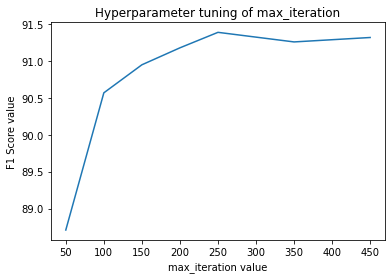

In [30]:
max_iteration_list = [50,100,150,200,250,350,450]
f1_score_list = [88.71, 90.57,90.95,91.18,91.39,91.26,91.32]

sns.lineplot(x=max_iteration_list,y=f1_score_list)
plt.xlabel("max_iteration value")
plt.ylabel("F1 Score value")
plt.title("Hyperparameter tuning of max_iteration")

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [31]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [32]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9196369904608155

### Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

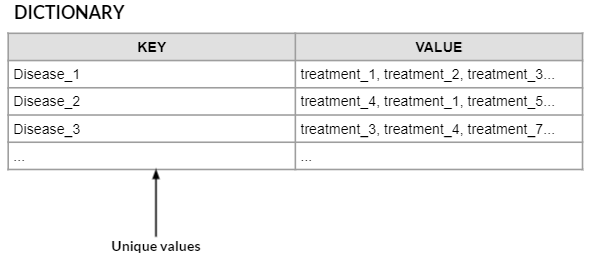

In [33]:
## Mapping diseases with treatment using test sentences and labels 
Mapping_dict=dict()

for lbl in range(0, len(Y_pred)):
  disease_sent=""
  treatment_sent=""
  label=Y_pred[lbl]
  for j in range(0, len(label)):
    if label[j]=='D':
      disease_sent=disease_sent+processed_test_sentences[lbl].split()[j]+" "
    if label[j]=='T':
      treatment_sent=treatment_sent+processed_test_sentences[lbl].split()[j]+" "
    
  disease_sent=disease_sent.lstrip().rstrip()
  treatment_sent=treatment_sent.lstrip().rstrip()
  
  
  if disease_sent!='' and treatment_sent!='':
    if disease_sent in Mapping_dict.keys():
      existing_disease_treatment=list(Mapping_dict[disease_sent]) 
      existing_disease_treatment.append(treatment_sent)
      Mapping_dict[disease_sent]=existing_disease_treatment
    else:
      Mapping_dict[disease_sent]=treatment_sent

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [34]:
Mapping_dict['hereditary retinoblastoma']

'radiotherapy'

In [35]:
result = []
for i in range(0, len(processed_test_sentences)):
    if 'retinoblastoma' in processed_test_sentences[i]:
        print("This is sentence number ", i , "in test data.")
        print("\n*****Sentence*****")
        print(processed_test_sentences[i])
        print("\n*****Test Label*****")
        print(processed_test_labels[i]) 
        print("\n*****Predicted Label*****")
        print(" ".join(Y_pred[i]))

This is sentence number  46 in test data.

*****Sentence*****
< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy

*****Test Label*****
O O O O O O O O O O O O O O O O O O O O O O O O O

*****Predicted Label*****
O O O O O O O O O O O O O O O O O D D O O O O O T
